In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, Convolution1D, MaxPooling2D
from keras.utils import np_utils
from keras.backend.common import _FLOATX
import pprint
import inspect
K.set_image_dim_ordering('th')

In [5]:
class BpZeroLayer(Convolution2D):
    '''
    Make a 2d convolution that blacks out all but one filter
    '''
    def __init__(self, filter_index, input_filters):
        super(BpZeroLayer, self).__init__(16, 1,  1, trainable=False, border_mode='same', weights=[np.array([ [ [[1]] if i == filter_index else [[0]] for i in range(0,input_filters) ] for j in range(0, input_filters)]), np.zeros(input_filters)])

In [6]:
# Create a new model with the first 4 layers of the original model created in example_keras_cnn.py

ex_model = load_model('example_model.h5')

model = Sequential()
inp = 4
for i in range(0,inp):
    model.add(ex_model.layers[i])
#for i in range(inp,  len(ex_model.layers)):
#    model.add(ex_model.layers[i])

del ex_model

In [7]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape data
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)


X_train shape: (60000, 1, 28, 28)


In [13]:

def get_max_location(result, filter_number):
    a = result[0][filter_number]
    return np.unravel_index(a.argmax(), a.shape)

# Not sure 'bout this calculation at all.
def get_max_patch(result, filter_number, image):
    max_location = get_max_location(result, filter_number)
    width_ratio = 2#image.shape[1] / result.shape[3]
    height_ratio = 2#image.shape[0] / result.shape[2]
    patch_top = int(max_location[0] * height_ratio-4)
    patch_left = int(max_location[1] * width_ratio-4)
    return image[patch_top:patch_top+8, patch_left:patch_left+8]

def get_max_value(result, filter_number):
    max_location = get_max_location(result, filter_number)
    return result[0][filter_number][max_location[0], max_location[1]]


def max_patches(dataset, predictions=np.array([]), filter_number=0, n=9):
    # Note: no more than 1 patch per image... not mathematically sound, but works well enough.
    if predictions.shape[0] != dataset.shape[0]:
        predictions = model.predict_on_batch(dataset)

    maxes = [-get_max_value([p], filter_number) for p in predictions]
    order = np.argsort(maxes)
    
    max_patches = [
        get_max_patch(np.array([predictions[max_image]]), filter_number, dataset[max_image][0])
        for max_image in order[:n]
    ]
    return max_patches



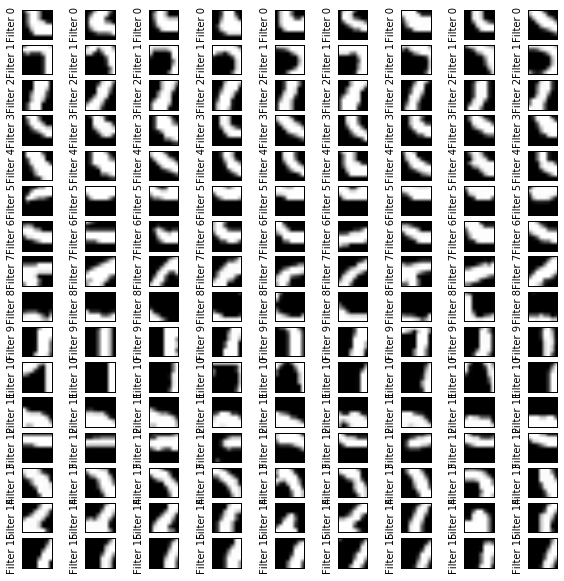

In [14]:
# Get the 9 patches that most activate each filter, and visualize them
n=9
dataset = X_train[:400]

predictions = model.predict_on_batch(dataset)
plt.figure(figsize=(10, 10))
for filter_number in range(16):
    patches = max_patches(dataset, predictions=predictions, filter_number=filter_number, n=n)
    for i in range(n):
        plt.subplot(16,9,filter_number*n+i+1)
        plt.ylabel("Filter {:}".format(filter_number))
        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])
        plt.imshow(patches[i], cmap='gray')


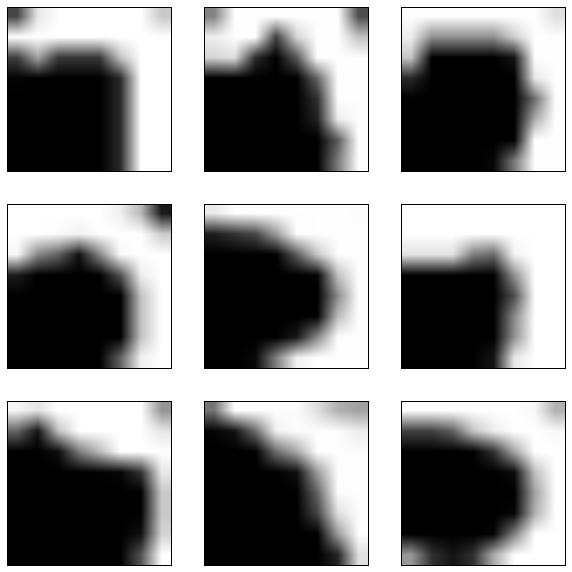

In [7]:
# Visualize for a single filter

filter_number = 1
patches = max_patches(dataset, filter_number=filter_number, n=n)

plt.figure(figsize=(10, 10))
for i in range(n):
    plt.subplot(3,3, i+1)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.imshow(patches[i], cmap='gray')



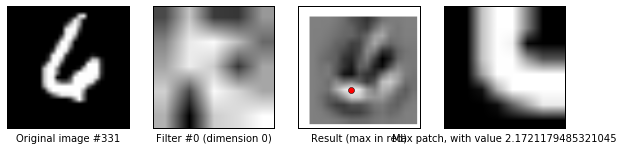

In [255]:
# Old viz stuff

image_number = 331#59915
image = X_train[image_number][0]
filter_number = 0

result = model.predict_on_batch(np.array([[image]]))
max_location = get_max_location(result, filter_number)



plt.figure(figsize=(10, 10))


#### SHOW ORIGINAL IMAGE
plt.subplot(1,4, 1)
plt.imshow(image, cmap='gray')
plt.xlabel("Original image #{:}".format(image_number))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])


### SHOW FILTER
plt.subplot(1,4, 2)
# get_weights returns a list of numpy arrays. 2nd
# Shape is [outgoing_layers][incoming_layers][filter_dimension1][filter_dimension2]
plt.imshow(model.layers[-1].get_weights()[filter_number][0][0], cmap='gray')
plt.xlabel("Filter #{:} (dimension 0)".format(filter_number))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])


### SHOW RESULT
plt.subplot(1,4, 3)
plt.imshow(result[0][filter_number], cmap='gray')
plt.plot([max_location[1]],[max_location[0]], 'ro')
plt.xlabel("Result (max in red)")
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])

### SHOW (max) PATCH
plt.subplot(1,4, 4)
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.imshow(get_max_patch(result, filter_number, image), cmap='gray')
plt.xlabel("Max patch, with value {:}".format(get_max_value(result, filter_number)))


In [25]:
import max_patch
model = load_model('example_model.h5')

(28, 28)
(3, 7) 0 0
(3, 7) * (1, 1, 28, 28) / (14, 14)
(4, 7) 0 0
(4, 7) * (1, 1, 28, 28) / (14, 14)
(4, 7) 0 0
(4, 7) * (1, 1, 28, 28) / (14, 14)
(4, 8) 0 0
(4, 8) * (1, 1, 28, 28) / (14, 14)
(4, 8) 0 0
(4, 8) * (1, 1, 28, 28) / (14, 14)


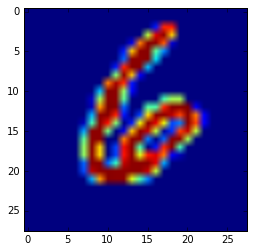

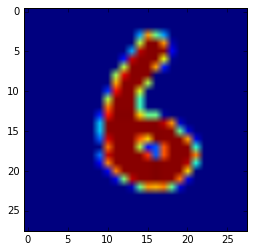

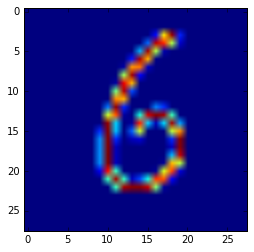

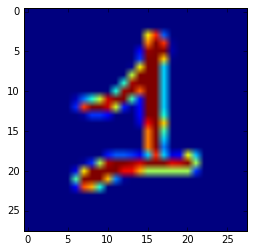

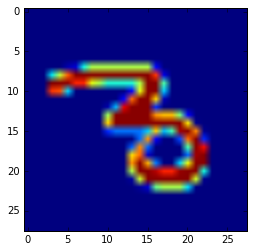

In [46]:
import imp
imp.reload(max_patch)
data = [np.array([image]) for image in X_train[:50]] #(1x1x28x28)
images = [image[0] for image in X_train[:50]] # (28x28)
patches = max_patch.max_patch(model, data, images, layer_number=3, filter_number=2, patch_size=(1,1), number_of_patches=5)

for patch in patches:
    plt.figure()
    plt.imshow(patch[0][0])
    plt.show()

In [41]:
(1,2,3)[-1]

3